In [1]:
!pip install -q -U pytorch-lightning datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 53.2 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PROJECT_PATH = "/content/drive/MyDrive/MyProject/brain-tumor-ai/Models/2D_Classifier_Binary"

CHECKPOINT_PATH = "/content/drive/MyDrive/MyProject/brain-tumor-ai/Models/2D_Classifier_Binary/checkpoint/best-finetune-epoch=29-val_loss=0.05.ckpt"

In [5]:
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

In [6]:
from module import Hybrid_PLmodule
from datamodule import DataModule

In [7]:
ds = load_dataset("Cayanaaa/BrainTumorDatasets", name="binary")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

binary/train-00000-of-00001.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

binary/test-00000-of-00001.parquet:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/810 [00:00<?, ? examples/s]

In [8]:
test_data = ds['test']
images = test_data['image']
labels = test_data['label']

In [9]:
labels_unique = np.unique(labels)
print(labels_unique)

[0 1]


In [10]:
type(images), type(labels)

(datasets.arrow_dataset.Column, datasets.arrow_dataset.Column)

In [11]:
data_module = DataModule(
    test_data = (images, labels),
    batch_size = 64,
    num_workers=2
)

In [12]:
backbone = models.densenet121(pretrained=True)
num_features = backbone.classifier.in_features
backbone.classifier = nn.Linear(num_features, 2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
model = Hybrid_PLmodule.load_from_checkpoint(CHECKPOINT_PATH, strict=False, backbone=backbone, num_classes=2)
model.set_criterion(criterion)

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


In [15]:
trainer = pl.Trainer(
    accelerator = "gpu",
    devices = 1
)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
trainer.test(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9938271641731262     │
│        test_auroc         │    0.9998597502708435     │
│         test_loss         │   0.019785892218351364    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.019785892218351364,
  'test_acc': 0.9938271641731262,
  'test_auroc': 0.9998597502708435}]

Confusion Matrix:
[[404   1]
 [  4 401]]


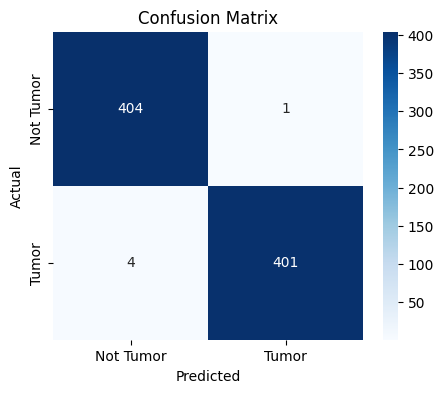


Classification Report:
              precision    recall  f1-score   support

           0     0.9902    0.9975    0.9938       405
           1     0.9975    0.9901    0.9938       405

    accuracy                         0.9938       810
   macro avg     0.9939    0.9938    0.9938       810
weighted avg     0.9939    0.9938    0.9938       810



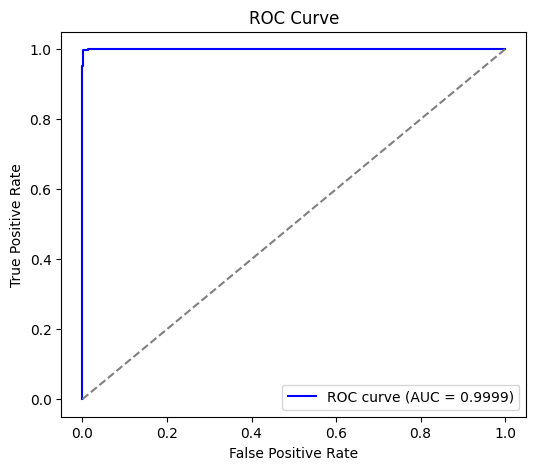

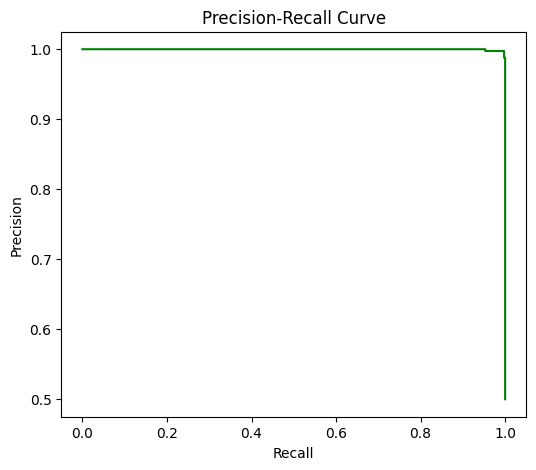


Matthews Correlation Coefficient (MCC): 0.9877


In [17]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

all_probs = []
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in data_module.test_dataloader():
        x = x.to(model.device)
        outputs = model(x)  # logits shape [B, 2]
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        preds = (probs > 0.5).astype(int)  # Threshold 0.5

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{cm}")
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Tumor', 'Tumor'], yticklabels=['Not Tumor', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# ROC Curve (pakai probabilitas)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve (pakai probabilitas)
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")
